In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
def get_normalized_data_MNIST():
    df = pd.read_csv('./train.csv')
    data = df.values.astype(np.float32)
    np.random.shuffle(data)
    X = data[:, 1:]
    Y = data[:, 0]

    Xtrain = X[:-1000]
    Ytrain = Y[:-1000]
    Xtest  = X[-1000:]
    Ytest  = Y[-1000:]
    
    mu = Xtrain.mean(axis=0)
    std = Xtrain.std(axis=0)

    np.place(std, std == 0, 1)

    Xtrain = (Xtrain - mu) / std
    Xtest = (Xtest - mu) / std
    
    Ytrain_ind = y2indicator(Ytrain)
    Ytest_ind = y2indicator(Ytest)
    
    Xtrain = Xtrain.astype(np.float32)
    Xtest = Xtest.astype(np.float32)
    Ytrain = Ytrain.astype(np.float32)
    Ytest = Ytest.astype(np.float32)
    Ytrain_ind = Ytrain_ind.astype(np.float32)
    Ytest_ind= Ytest_ind.astype(np.float32)
    

    return Xtrain, Ytrain, Xtest, Ytest, Ytrain_ind, Ytest_ind

In [3]:
def y2indicator(y):

    y = y.astype(np.int32)
    ind = np.zeros((len(y), 10))

    for i in range(len(y)):
        ind[i, y[i]] = 1
        
    return ind.astype(np.float32)

In [4]:
class HiddenLayers(object):
    def __init__(self, M1, M2, f):
        self.M1 = M1
        self.M2 = M2
        self.f = f
                
        W_init = np.random.randn(M1, M2)*np.sqrt(2/M1)
        b_init = np.zeros(M2)
        
        self.W = tf.Variable(W_init.astype(np.float32))
        self.b = tf.Variable(b_init.astype(np.float32))
        
    def forward(self, X):
        return self.f(tf.matmul(X, self.W)+ self.b)
        

In [15]:
class HiddenLayersBatchNorm(object):
    def __init__(self, M1, M2, f):
        self.M1 = M1
        self.M2 = M2
        self.f = f
        
        W_init = np.random.randn(M1, M2)*np.sqrt(2/M1)
        #no b term. 
        gamma_init = np.ones(M2).astype(np.float32)
        beta_init = np.zeros(M2).astype(np.float32)
        
        self.W = tf.Variable(W_init.astype(np.float32))
        self.gamma = tf.Variable(gamma_init.astype(np.float32))
        self.beta = tf.Variable(beta_init.astype(np.float32))
        
        #for the test
        running_mean_init = np.zeros(M2).astype(np.float32)
        running_var_init = np.zeros(M2).astype(np.float32)
        
        self.running_mean = tf.Variable(running_mean_init.astype(np.float32), trainable=False)
        self.running_var = tf.Variable(running_var_init.astype(np.float32), trainable=False)
    
    def forward(self, X, is_training, decay = 0.9):
        activation = tf.matmul(X, self.W)
        
        if is_training:
            batch_mean, batch_var = tf.nn.moments(activation, [0])
            update_running_mean = tf.assign(self.running_mean, self.running_mean * decay + batch_mean * (1 - decay))
            update_running_var = tf.assign(self.running_var, self.running_var * decay + batch_var * (1 - decay))
            
            with tf.control_dependencies([update_running_mean, update_running_var]):
                out = tf.nn.batch_normalization(activation, batch_mean, batch_var, self.beta, self.gamma, 1e-4)
            
            
        else:
            out = tf.nn.batch_normalization(activation, self.running_mean, self.running_var, self.beta, self.gamma, 1e-4)
            
        return out
    
#tf.nn.moments(X, axis)
# x is tensor 
# axis = [0,1,2] = [batch, height, width]
    
#tf.nn.batch_normalization(x, mean, variance, offset, scale, variance_epsilon, name=None) 
#x: Input Tensor of arbitrary dimensionality.
#mean: A mean Tensor.
#variance: A variance Tensor.
#offset: An offset Tensor, often denoted \(\beta\) in equations, or None. If present, will be added to the normalized tensor.
#scale: A scale Tensor, often denoted \(\gamma\) in equations, or None. If present, the scale is applied to the normalized tensor.
#variance_epsilon: A small float number to avoid dividing by 0.
#name: A name for this operation (optional).

#tf.control_dependencies(control_inputs) 
# -- When eager execution is enabled, any callable object in the control_inputs list will be called.
#control_inputs: A list of Operation or Tensor objects which must be executed or computed 
# before running the operations defined in the context. 
# Can also be None to clear the control dependencies. 
# If eager execution is enabled, any callable object in the control_inputs list will be called.

In [30]:
class ANN(object):
    def __init__(self, hidden_layer_sizes):
        self.hidden_layer_sizes = hidden_layer_sizes
            
    def fit(self, Xtrain, Ytrain, Xtest, Ytest, Ytrain_ind, Ytest_ind, activation = tf.nn.relu, lr=1e-4, max_iter=15, batch_sz=500, print_period=100):
        print("ANN")
        
        #initialize hidden layers
        N, D = Xtrain.shape
        K = Ytrain_ind.shape[1]
        
        
        M1 = D
        
        self.layers = []
        for M2 in self.hidden_layer_sizes:
            h = HiddenLayers(M1, M2, activation)
            self.layers.append(h)
            M1 = M2
        
        #final layer
        h = HiddenLayers(M2, K, lambda x : x)
        self.layers.append(h)
        
        
        tfX = tf.placeholder(tf.float32, shape=(None, D), name='X')
        tfT = tf.placeholder(tf.float32, shape=(None, K), name='T')
        
        
        Yish = self.forward(tfX)
        
        cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Yish, labels=tfT))
        
        train_op = tf.train.AdamOptimizer(learning_rate = lr).minimize(cost)
        predict_op = tf.argmax(Yish, 1)
        
        n_batches = N // batch_sz
        self.costs = []
        
        init = tf.global_variables_initializer()
        with tf.Session() as session:
            session.run(init)

            for i in range(max_iter):
                for j in range(n_batches):
                    Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
                    Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

                    session.run(train_op, feed_dict={tfX: Xbatch, tfT: Ybatch})
                    if j % print_period == 0:
                        test_cost = session.run(cost, feed_dict={tfX: Xtest, tfT: Ytest_ind})
                        prediction = session.run(predict_op, feed_dict={tfX: Xtest})
                        err = self.error_rate(prediction, Ytest)
                        print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, test_cost, err))
                        self.costs.append(test_cost)
    
    def show_fig(self):
        plt.plot(self.costs)
        plt.title("ANN")
        plt.show()
    
    
    def forward(self, X):
        out = X
        for h in self.layers[:-1]:
            out = h.forward(out)
        out = self.layers[-1].forward(out)
        return out
    
    def error_rate(self, p, t):
        return np.mean(p != t)

In [31]:
class ANN_with_Batch_Norm(object):
    def __init__(self, hidden_layer_sizes):
        self.hidden_layer_sizes = hidden_layer_sizes
            
    def fit(self, Xtrain, Ytrain, Xtest, Ytest, Ytrain_ind, Ytest_ind, activation = tf.nn.relu, lr=1e-4, max_iter=15, batch_sz=500, print_period=100):
        print("ANN with batch normalization")
        #initialize hidden layers
        N, D = Xtrain.shape
        K = Ytrain_ind.shape[1]
        
        
        M1 = D
        
        self.layers = []
        for M2 in self.hidden_layer_sizes:
            h = HiddenLayersBatchNorm(M1, M2, activation)
            self.layers.append(h)
            M1 = M2
        
        #final layer
        h = HiddenLayers(M2, K, lambda x : x)
        self.layers.append(h)
               
             
        tfX = tf.placeholder(tf.float32, shape=(None, D), name='X')
        tfT = tf.placeholder(tf.float32, shape=(None, K), name='T')
        
        
        Yish = self.forward(tfX, is_training = True)
        
        cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Yish, labels=tfT))
        
        Yish_test = self.forward(tfX, is_training = False )
        train_op = tf.train.MomentumOptimizer(lr,  momentum=0.9, use_nesterov=True).minimize(cost)
        predict_op = tf.argmax(Yish_test, 1)
        
        n_batches = N // batch_sz
        self.costs = []
        
        init = tf.global_variables_initializer()
        with tf.Session() as session:
            session.run(init)

            for i in range(max_iter):
                for j in range(n_batches):
                    Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
                    Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

                    session.run(train_op, feed_dict={tfX: Xbatch, tfT: Ybatch})
                    if j % print_period == 0:
                        test_cost = session.run(cost, feed_dict={tfX: Xtest, tfT: Ytest_ind})
                        prediction = session.run(predict_op, feed_dict={tfX: Xtest})
                        err = self.error_rate(prediction, Ytest)
                        print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, test_cost, err))
                        self.costs.append(test_cost)

    def show_fig(self):
        plt.plot(self.costs)
        plt.title("ANN with Batch Norm")
        plt.show()
            
    def forward(self, X, is_training):
        out = X
        for h in self.layers[:-1]:
            out = h.forward(out, is_training)
        out = self.layers[-1].forward(out)
        return out
    
    def error_rate(self, p, t):
        return np.mean(p != t)

In [36]:
def main():
    # step 1: get the data and define all the usual variables
    Xtrain, Ytrain, Xtest, Ytest, Ytrain_ind, Ytest_ind = get_normalized_data_MNIST()
    
    ann = ANN([500, 300, 100])
    ann.fit(Xtrain, Ytrain, Xtest, Ytest, Ytrain_ind, Ytest_ind)
    ann.show_fig()
    
    ann_w_bn = ANN_with_Batch_Norm([500, 300, 100])
    ann_w_bn.fit(Xtrain, Ytrain, Xtest, Ytest, Ytrain_ind, Ytest_ind)
    ann_w_bn.show_fig()
    
    x1 = np.linspace(0, 15, len(ann.costs))
    plt.plot(x1, ann.costs, label="ANN")
    x2 = np.linspace(0, 15, len(ann_w_bn.costs))
    plt.plot(x2, ann_w_bn.costs, label="Batch Normalization")
    plt.legend()
    plt.show()

ANN
Cost / err at iteration i=0, j=0: 3041.655 / 0.859
Cost / err at iteration i=1, j=0: 501.288 / 0.138
Cost / err at iteration i=2, j=0: 310.870 / 0.094
Cost / err at iteration i=3, j=0: 246.940 / 0.074
Cost / err at iteration i=4, j=0: 208.275 / 0.060
Cost / err at iteration i=5, j=0: 184.917 / 0.057
Cost / err at iteration i=6, j=0: 168.462 / 0.052
Cost / err at iteration i=7, j=0: 156.954 / 0.049
Cost / err at iteration i=8, j=0: 148.156 / 0.048
Cost / err at iteration i=9, j=0: 141.534 / 0.047
Cost / err at iteration i=10, j=0: 136.410 / 0.042
Cost / err at iteration i=11, j=0: 132.618 / 0.040
Cost / err at iteration i=12, j=0: 129.388 / 0.038
Cost / err at iteration i=13, j=0: 126.909 / 0.039
Cost / err at iteration i=14, j=0: 124.615 / 0.036


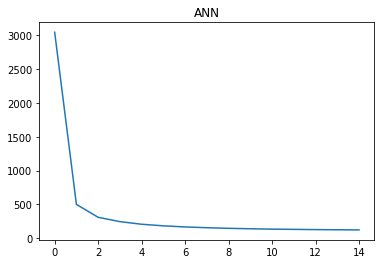

ANN with batch normalization
Cost / err at iteration i=0, j=0: 1527.678 / 0.460
Cost / err at iteration i=1, j=0: 326.499 / 0.088
Cost / err at iteration i=2, j=0: 304.671 / 0.084
Cost / err at iteration i=3, j=0: 317.819 / 0.085
Cost / err at iteration i=4, j=0: 303.489 / 0.082
Cost / err at iteration i=5, j=0: 310.773 / 0.084
Cost / err at iteration i=6, j=0: 300.541 / 0.086
Cost / err at iteration i=7, j=0: 310.933 / 0.086
Cost / err at iteration i=8, j=0: 311.637 / 0.086
Cost / err at iteration i=9, j=0: 319.033 / 0.087
Cost / err at iteration i=10, j=0: 315.780 / 0.089
Cost / err at iteration i=11, j=0: 337.056 / 0.086
Cost / err at iteration i=12, j=0: 327.269 / 0.087
Cost / err at iteration i=13, j=0: 342.952 / 0.086
Cost / err at iteration i=14, j=0: 336.072 / 0.087


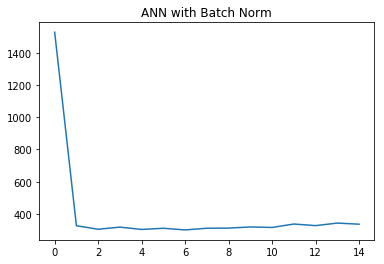

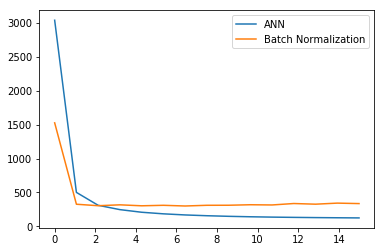

In [37]:
if __name__ == '__main__':
    main()